#1.A/B test Project

### Background Scenario

다솔이는 myrealtrip의 데이터분석가로 입사를 하게 되었습니다. 마케팅팀에서 웹페이지 변경 건 관련 A/B 테스트를 요청하셨습니다. 팀장님께 보고드린 후 해당 분석을 담당하게 되었습니다. google analytics(GA)를 활용하여 funnel을 살펴본 결과, 장바구니에서 결제로 이어지는 구간에서 가장 큰 이탈이 있는 것으로 확인되었습니다.  

현재 장바구니에서 결제로 전환되는 비율은 23%였으며, 마케팅팀과 협의하여 25%로 전환율을 올리면 해당 분석은 성공한 것으로 간주하기로 협의하였습니다.  



### 🔶 A/B test 상세내역 
- 목표 지수 : 전환율 2 % 상승 ( 장바구니 -> 결제 ) 
- 기간 : 21일 ( 주중, 주말간의 고객의 행동패턴을 모두 포함하여야 하기에 21일로 설정 )
- 가설 : 우리는 결제 페이지의 디자인을 변경하여 구매 전환율을 2% 이상 증가할 것이다.   
  ( 신뢰도 : 95%  /  α:0.05  /  One- and two-tailed tests 사용 : 전환율을 낮아질 수도 있음 )
- A/B테스트 내용 : 
- 지표확인 :   

(단, myrealtrip의 기존 데이터가 누적되어 있고 고객들의 행동패턴을 사전에 파악하고 있다고 가정하고 해당 분석에서는  A/A test는 진행하지 않도록 하겠습니다.)

### google drive connection

In [1]:
cd drive/MyDrive/data/

/content/drive/MyDrive/data


In [2]:
ls

 금융/                                   behavioral_pattern_analysis.csv
 스마트폰_로그_데이터셋2.json            cookie_cats.csv
 ab_data.csv                             FMbest.hdf5
'AB_test and Cohort analytic data.csv'   스마트폰_로그_데이터셋.json


### Data imformation

feature 
 - user_id : 고객의 id 정보 
 - timestamp : 고객이 이용한 시간 
 - group : A/B test에서 고객이 어디에 속하는지 
 - landing_page : 랜딩된 페이지가 무엇인지 
 - converted : 전환여부 
  * 0 : 사용자가 이 세션을 이용하는 동안 상품을 구매하지 않음
  * 1 : 사용자가 이 세션을 이용하는 동안 상품을 구매함

데이터 출처 : kaggle 

### Data load

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

df = pd.read_csv("ab_data.csv")

In [4]:
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


### Data check

In [5]:
df.shape

(294478, 5)

In [6]:
# user_id는 index 수와 다른 것을 보아 중복된 id가 있는 것으로 관측됩니다. 
# timestamp도 결측치 없이 모두 잘 들어가 있는 것을 확인할 수 있습니다. 
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [7]:
# kaggle에서 데이터를 불러오다보니 데이터가 깨끗하여 아쉬습니다.
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
# timestamp의 경우, object로 되어 있어서 날짜형식으로 변경이 필요
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
# 사실상 describe를 살펴보아야할 feature는 없지만, 그래도 이상한 값이 있을 수 있으니 체크
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0


In [10]:
df.timestamp.max(), df.timestamp.min()  

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

총 21일 실험을 진행합니다.   
그러나, 시작하는 일자와 종료하는 일자에 온전한 test가 이루어진다고 볼 수 없으니,   
시작일과 종료일을 포함하여 총 23일 실험이 진행되었습니다. 

In [11]:
# 각 그룹별 랜딩페이지도 믹스되어 있고, 전환여부도 믹스되어 있는 것을 관측할 수 있습니다. 
# 한 그룹에서 웹페이지가 변경되었다고 해서 바로 전환율을 확인할 수 없기에 통계적으로 살펴볼 필요가 있습니다. 
# 또한, 각 그룹에서 샘플링을 진행할 때 중복으로 입력될 수 있기 때문에 주의가 필요합니다.
# ( 일반적인 경우, 샘플링은 진행하지 않으나, 해당 프로젝트는 실제 분석을 최대한 유사하게 진행하기 위해 샘플링을 진행합니다 )
df[["group",	"landing_page", "converted"]].value_counts()

group      landing_page  converted
treatment  new_page      0            128047
control    old_page      0            127785
                         1             17489
treatment  new_page      1             17264
           old_page      0              1715
control    new_page      0              1694
treatment  old_page      1               250
control    new_page      1               234
dtype: int64

In [12]:
# converted를 제외하고 데이터를 살펴보겠습니다. 
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


### EDA

In [13]:
# timestampe 데이터 유형 변경 및 date, hour feature 생성 
df['timestamp'] = pd.to_datetime(df['timestamp'])
df["date"] = df['timestamp'].dt.strftime('%Y-%m-%d')
df["hour"] = df["timestamp"].dt.hour
df["day-of-week"] = df["timestamp"].dt.day_name()   

df.head(2)

,user_id,timestamp,group,landing_page,converted,date,hour,day-of-week
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21,22,Saturday
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12,8,Thursday


In [14]:
df = df.sort_values(by='date' ,ascending=True)
df.head(2)

,user_id,timestamp,group,landing_page,converted,date,hour,day-of-week
245040,637212,2017-01-02 17:40:36.776831,treatment,new_page,1,2017-01-02,17,Monday
27445,924138,2017-01-02 20:35:46.666785,treatment,new_page,0,2017-01-02,20,Monday


### 시각화

<BarContainer object of 23 artists>

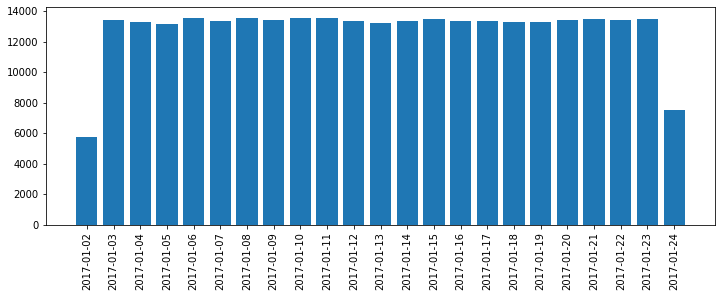

In [15]:
date = df.date.value_counts().to_frame().sort_index()

plt.figure(figsize=(12,4))
plt.xticks(rotation =90)
plt.bar(date.index, date.date)

각 그룹별로 일자 현황을 확인하기 위해 다시 한번 그래프를 그려보겠습니다. 

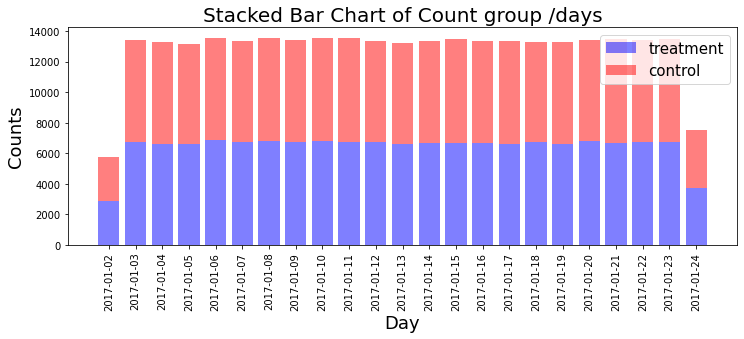

In [16]:
plt.figure(figsize=(12,4))

df_group_control = df[df['group'] == 'control'].groupby('date').count()["group"]
df_group_treatment = df[df['group'] == 'treatment'].groupby('date').count()["group"]
alpha = 0.5

p1 = plt.bar(df_group_control.index, df_group_treatment, color='b', alpha=alpha)
p2 = plt.bar(df_group_control.index, df_group_control, color='r', alpha=alpha, bottom=df_group_treatment) 

plt.title('Stacked Bar Chart of Count group /days', fontsize=20)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Day', fontsize=18)
plt.xticks(rotation =90)
plt.legend((p1[0], p2[0]), ('treatment', 'control'), fontsize=15)

plt.show()

총 3주간 데이터를 관측하였으며, 2017-01-03 ~ 2017-01-23을 실험기간으로 간주합니다. 

<Figure size 864x864 with 0 Axes>

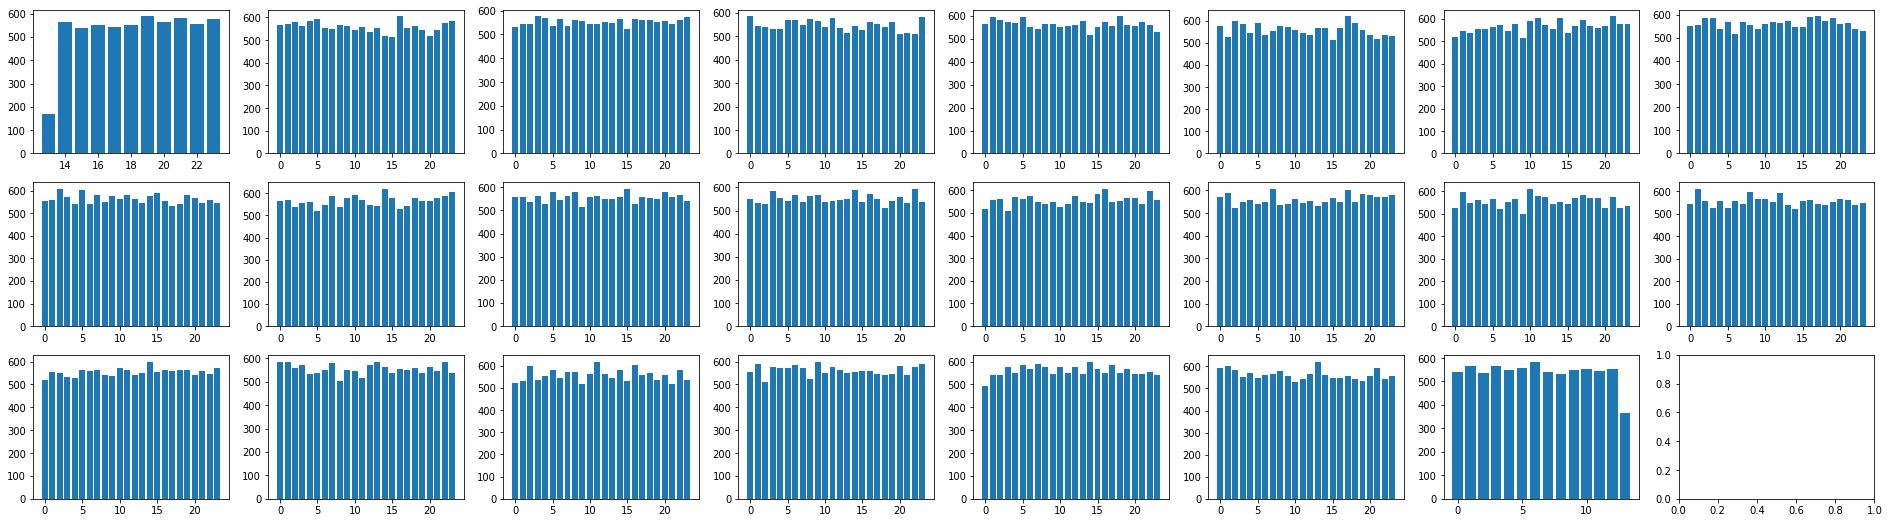

In [17]:
plt.figure(figsize=(12,12))
import seaborn as sns
dt = df[['date','hour', "user_id"]].groupby(['date','hour']).count()
dt = dt.reset_index().set_index('date')

fig = plt.figure(figsize=(33,9))
axes = fig.subplots(nrows=3, ncols=8)
a = 3
b = 8 
c = 1 

for i in dt.index.unique().tolist():
  plt.subplot(a, b, c)
  day_hour_user = dt[dt.index == i]
  plt.bar(day_hour_user.hour, day_hour_user.user_id)
  c = c + 1

plt.show()

모든 시간에서 고르게 사용자들이 관측됩니다. 일반적으로 수면 시간에는 이용하는 횟수가 감소되는 경향을 관측되나, 글로벌 데이터로 실험을 진행하다보니 모든 시간대에 고객이 관측되었다.

### 표본설정

본격적인 분석에 앞서서 표본을 설정하는 작업이 필요합니다.  
일반적인 A/B test의 경우, 유입되는 고객을 모두 사용하거나, Max값을 설정하거나, 분석 방향에 따라서 각각의 표본의 크기를 결정합니다. 표본의 크기는 p-value의 민감도에 영향을 주기 때문에 적정한 표본의 크기는 중요하다고 생각하였습니다. ( 표본 커질수록 p-value는 작아지기 때문입니다. )    

표본의 크기는 검정력 분석(power of test)로 구할 수 있으며, 관례적으로 power를 0.8로 사용하기에 해당 프로젝트에서도 0.8로 활용하도록 하겠습니다. 

In [18]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import scipy.stats as stats 
import statsmodels.stats.api as sms 
from math import ceil 

# 예상 비율을 기반으로 effectsize(효과) 계산 
effect_size = sms.proportion_effectsize(0.23, 0.25) 

# 샘플 크기 구하기 
sample_size = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)

# 즉, A,B 그룹에 최소 7155명의 고객 수 필요 
print("sample_size : ", round(sample_size), "명") 
print("effect_size : ", effect_size.round(5))

sample_size :  7155 명
effect_size :  -0.04684


In [19]:
# 위에서 세션이 만료되어 중복된 user_id가 있는 것을 확인하였습니다. 
session_counts = df['user_id'].value_counts(ascending=False) 

# 중복된 유저 수 확인 
print(session_counts[session_counts > 1].count(),"명")

3894 명


In [20]:
# 중복된 유저를 multi_users로 지정 후 index를 multi_users_drop에 지정합니다. 
multi_users = session_counts[session_counts > 1].count() 
multi_users_drop = session_counts[session_counts > 1].index 

In [21]:
# 중복 유저 제거 
df = df[~df['user_id'].isin(multi_users_drop)] 
df.shape[0]

286690

In [22]:
# 이제 랜덤하게 샘플링을 진행하겠습니다. 
# 최소 필요한 샘플 인원은 7155였습니다. 그런데,홀수이기에 짝수로 구성하기 위해 7200으로 sample_size를 설정하겠습니다. 
control_group = df[df['group'] == 'control'].sample(n=7200, random_state=42)
treatment_group = df[df['group'] == 'treatment'].sample(n=7200, random_state=42)

ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(drop=True, inplace=True)

# 샘플링이 잘 되었는지 확인 합니다. 
print("shape : ", ab_test.shape)
print("group rate :")
print(ab_test.group.value_counts(normalize=True))

shape :  (14400, 8)
group rate :
control      0.5
treatment    0.5
Name: group, dtype: float64


In [23]:
ab_test.head(2)

,user_id,timestamp,group,landing_page,converted,date,hour,day-of-week
0,749770,2017-01-24 07:09:19.807944,control,old_page,0,2017-01-24,7,Tuesday
1,943821,2017-01-22 00:14:36.031806,control,old_page,0,2017-01-22,0,Sunday


### conversion rate 

In [24]:
# 전환율을 계산해봅니다. 
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion 구하기 
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n)) 구하기 

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.116,0.321,0.004
treatment,0.118,0.323,0.004


전환율을 계산하였을 때, 0.116 -> 0.118로 소폭의 상승이 있었습니다.  
과연, 해당 숫자가 통계적으로 유의한지 확인이 필요합니다. 


### A/B test

A/B test 절차 
 - 일단 그룹을 나눕니다. (함수로 다시 제작하기에 해당 과정을 다시 한번 진행하겠습니다.)
 - 정규성을 확인하기 위해 Shapiro-wilk test를 진행합니다. 
 - 만약, 정규분포라면 Levene test를 진행하여 두 그룹간의 분산이 같은지 확인합니다.   
 그렇지 않다면, Mann Whitney U Test로 두집단을 비교합니다. 
 - Levene test를 통과하였다면, t-test를 진행하여 평균이 같은지 확인합니다. 
 - 만약 Levene test를 통과하지 못하였다면, apply Welch test로 평균을 확인합니다. 
 - A/B test에 대한 자세한 설명은 블로그로 따로 정리하였습니다. 해당 링크를 참고 부탁드립니다. https://daje0601.tistory.com/267

In [25]:
# A/B Testing 함수
def AB_Test(dataframe, group, target):
    
    # 라이브러리 
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # 데이터 샘플링 
    groupA = dataframe[dataframe[group] == 'control'].sample(n=7200, random_state=42)[target]
    groupB = dataframe[dataframe[group] == 'treatment'].sample(n=7200, random_state=42)[target]

    # Normality(정규성) 확인하기 
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0(귀무가설): 정규분포이다. - 결과값 : False
    # H1(대립가설): 정규분포가 아니다. - 결과값 : True
    
    # "H0(귀무가설)이 성립할 경우, 데이터는 정규분포이므로 모수검정을 진행합니다. "
    if (ntA == False) & (ntB == False): 
        # 두 그룹간에 분산이 같은지를 확인합니다. 
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0(귀무가설): 두 그룹간의 분산이 같다. - 결과값 : False
        # H1(대립가설): 두 그룹간의 분산이 다르다. - 결과값 : True
        
        if leveneTest == False:
            # 분산이 같은 경우, t-test를 진행합니다. 
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0(귀무가설): 두 그룹간의 평균이 같다. - 결과값 : False
            # H1(대립가설): 두 그룹간의 평균이 다르다. - 결과값 : True
        else:
            # 분산이 다른 경우, leveneTest를 진행합니다. 
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0(귀무가설): 두 그룹간의 평균이 같다. - 결과값 : False
            # H1(대립가설): 두 그룹간의 평균이 다르다. - 결과값 : True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0(귀무가설): 두 그룹이 같다. - 결과값 : False
        # H1(대립가설): 두 그룹이 다르다. - 결과값 : True
        
    # 결과 도출 
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # 컬럼 생성 
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    

AB_Test(dataframe=ab_test, group = "group", target = "converted")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.3585,A/B groups are similar!


### Conclusion

결과값을 확인한 결과, sharpio-wilk test 결과, 정규분포를 따르지 않아 Non-Parametric 검정을 통하여 A/B test가 진행되었습니다. 
귀무가설을 기각할 수 없기에, A그룹과 B그룹은 유사한 것으로 판명이되었고, 저희가 변경한 웹디자인은 유효하지 않은 것으로 판명되었습니다. 이에, 빠르게 다른 가설을 설정하여 실험을 진행할 필요가 있습니다. 

---

#2.Cohort Analytics

google  Analytics으로 쉽게 코호드 분석을 할 수 있지만,   
파이썬으로 한번 구현보고, 인사이트를 도출해보고자 합니다. 

데이터 : 쇼핑몰 데이터  
출처 : github 

### Data load

In [26]:
df=pd.read_excel('https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx?raw=true', 
                 sheet_name='Purchase Data - Full Study')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


### Dat check

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       2891 non-null   int64         
 1   OrderDate     2891 non-null   datetime64[ns]
 2   UserId        2891 non-null   int64         
 3   TotalCharges  2891 non-null   float64       
 4   CommonId      2891 non-null   object        
 5   PupId         2891 non-null   int64         
 6   PickupDate    2891 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 158.2+ KB


In [28]:
# 숫자형 데이터에 대해 통계적 분포를 살펴보겠습니다.
# TotalCharges의 경우, min과 max값이 Q1, Q3과 차이가 크게 납니다. 이상치가 있는게 아닌지 의심스럽습니다. 
# 만약 머신러닝 모델링을 진행하였다면, 제거를 고려해보겠지만, 지금은 코호트 분석을 하기 때문에 어떤 값인지 살펴보도록만 하겠습니다. 
# 
df[["TotalCharges"]].describe()

,TotalCharges
count,2891.000000
mean,59.947184
std,55.009949
min,1.390000
25%,22.965000
50%,44.810000
75%,79.600000
max,690.982700


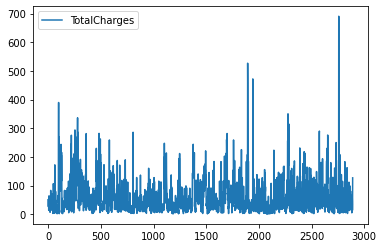

In [29]:
df[["TotalCharges"]].plot();

In [30]:
# 분석에 사용되지 않는 feature를 제거하도록 하겠습니다. 
df.drop(['CommonId','PupId','PickupDate','TotalCharges'],
        axis=1,inplace=True)

# 제거여부 확인 
df.head()

,OrderId,OrderDate,UserId
0,262,2009-01-11,47
1,278,2009-01-20,47
2,294,2009-02-03,47
3,301,2009-02-06,47
4,302,2009-02-06,47


In [31]:
df['OrderDate'].head()

0   2009-01-11
1   2009-01-20
2   2009-02-03
3   2009-02-06
4   2009-02-06
Name: OrderDate, dtype: datetime64[ns]

In [32]:
df['OrderDate'].dtype

dtype('<M8[ns]')

### EDA

In [33]:
# 코호트 분석은 특정 기간동안 사용자가 얼마나 구매를 하였는지, 우리 서비스를 유지하고 있는지를 확인하는 분석입니다. 
# 이에, 주문기간(OrderPeriod)을 확인할 수 있도록 연도와 월로 구성된 feature를 생성합니다. 

df['OrderPeriod']=df['OrderDate'].dt.strftime('%Y-%m')
df.head()

,OrderId,OrderDate,UserId,OrderPeriod
0,262,2009-01-11,47,2009-01
1,278,2009-01-20,47,2009-01
2,294,2009-02-03,47,2009-02
3,301,2009-02-06,47,2009-02
4,302,2009-02-06,47,2009-02


In [34]:
# 각 사용자가 최초 구매를 시작한 일자를 확인하기 위해 userId를 인덱스로 지정합니다. 
df.set_index('UserId',inplace=True)
df.head()

,OrderId,OrderDate,OrderPeriod
UserId,,,
47,262,2009-01-11,2009-01
47,278,2009-01-20,2009-01
47,294,2009-02-03,2009-02
47,301,2009-02-06,2009-02
47,302,2009-02-06,2009-02


In [35]:
# 각 사용자별로 제일 빠른 주문일자를 확인합니다. 
FirstOrder=df.groupby(df.index)['OrderDate'].min()
FirstOrder.head()

UserId
47    2009-01-11
95    2009-03-10
98    2009-01-29
112   2009-01-19
141   2009-11-13
Name: OrderDate, dtype: datetime64[ns]

In [36]:
# 제일 빠른 주문일자를 연도와 월로 확인합니다. 
FirstOrder=FirstOrder.dt.strftime('%Y-%m')
FirstOrder.head()

UserId
47     2009-01
95     2009-03
98     2009-01
112    2009-01
141    2009-11
Name: OrderDate, dtype: object

In [37]:
# 생성한 feature를 df에 추가하여 줍니다. 
df['FirstOrder']=FirstOrder
df.reset_index(inplace=True)
df.head()

,UserId,OrderId,OrderDate,OrderPeriod,FirstOrder
0,47,262,2009-01-11,2009-01,2009-01
1,47,278,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,2009-02,2009-01
3,47,301,2009-02-06,2009-02,2009-01
4,47,302,2009-02-06,2009-02,2009-01


In [38]:
# 주문횟수를 구하기 위해 처음구매한 일부터 각 월별로 몇번 구매하였는지 확인 합니다. 
grouped = df.groupby(['FirstOrder', 'OrderPeriod'])
cohorts=grouped['UserId'].nunique()
cohorts.head()

FirstOrder  OrderPeriod
2009-01     2009-01        22
            2009-02         8
            2009-03        10
            2009-04         9
            2009-05        10
Name: UserId, dtype: int64

In [39]:
# 최초 구매일자는 당연히 필요하므로, 인덱스에서 빼줍니다. 
cohorts=cohorts.reset_index()
cohorts.head()

,FirstOrder,OrderPeriod,UserId
0,2009-01,2009-01,22
1,2009-01,2009-02,8
2,2009-01,2009-03,10
3,2009-01,2009-04,9
4,2009-01,2009-05,10


In [40]:
# feature 이름 변경 
cohorts.rename({'UserId':'TotalUsers'},axis=1,inplace=True)
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2009-01,2009-01,22
1,2009-01,2009-02,8
2,2009-01,2009-03,10
3,2009-01,2009-04,9
4,2009-01,2009-05,10


In [41]:
# 코호트 분석기간은 2009-01부터 2010-03까지 입니다. 
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2009-01    15
2009-02    13
2009-03    13
2009-04    12
2009-05    11
2009-06    10
2009-07     9
2009-08     8
2009-09     7
2009-10     6
2009-11     5
2009-12     4
2010-01     3
2010-02     2
2010-03     1
Name: FirstOrder, dtype: int64

In [42]:
# 데이터가 잘 생성되었는지 확인합니다. 
cohorts[cohorts['FirstOrder']=='2009-02'].head(2)

,FirstOrder,OrderPeriod,TotalUsers
15,2009-02,2009-02,15
16,2009-02,2009-03,3


In [43]:
# 데이터가 없는 기간도 포함하여 코호트 분석을 진행하기 위하여 해당기간의 FirstOrder와 OrderPeriod를 입력하고 TotalUsers에 0을 입력합니다.
cohorts.loc[cohorts.shape[0],'FirstOrder']='2009-02'
cohorts.loc[cohorts.shape[0]-1,'OrderPeriod']='2010-03'
cohorts.loc[cohorts.shape[0]-1,'TotalUsers']=0
cohorts.sort_values(['FirstOrder','OrderPeriod'],inplace=True)

In [44]:
cohorts[cohorts['FirstOrder']=='2009-02']

,FirstOrder,OrderPeriod,TotalUsers
15,2009-02,2009-02,15.0
16,2009-02,2009-03,3.0
17,2009-02,2009-04,5.0
18,2009-02,2009-05,1.0
19,2009-02,2009-06,4.0
20,2009-02,2009-07,4.0
21,2009-02,2009-08,4.0
22,2009-02,2009-09,5.0
23,2009-02,2009-10,5.0
24,2009-02,2009-11,4.0


In [45]:
# 데이터가 잘 정렬되어 있는지 확인합니다. 
each_period=cohorts['FirstOrder'].value_counts().sort_index()
each_period

2009-01    15
2009-02    14
2009-03    13
2009-04    12
2009-05    11
2009-06    10
2009-07     9
2009-08     8
2009-09     7
2009-10     6
2009-11     5
2009-12     4
2010-01     3
2010-02     2
2010-03     1
Name: FirstOrder, dtype: int64

In [46]:
# 코호드 기간 feature를 생성합니다. 
cohortperiod=[]

for x in each_period: 
    for y in range(x):
        cohortperiod.append(y)

In [47]:
cohorts['CohortPeriod']=cohortperiod
cohorts.head(20)

,FirstOrder,OrderPeriod,TotalUsers,CohortPeriod
0,2009-01,2009-01,22.0,0
1,2009-01,2009-02,8.0,1
2,2009-01,2009-03,10.0,2
3,2009-01,2009-04,9.0,3
4,2009-01,2009-05,10.0,4
5,2009-01,2009-06,8.0,5
6,2009-01,2009-07,8.0,6
7,2009-01,2009-08,7.0,7
8,2009-01,2009-09,7.0,8
9,2009-01,2009-10,7.0,9


In [48]:
cohorts.set_index(['FirstOrder','CohortPeriod'],inplace=True)
cohorts.head()

OrderPeriod  TotalUsers
FirstOrder CohortPeriod                        
2009-01    0                2009-01        22.0
           1                2009-02         8.0
           2                2009-03        10.0
           3                2009-04         9.0
           4                2009-05        10.0

In [49]:
cohorts=cohorts['TotalUsers'].unstack(1)
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
FirstOrder,,,,,,,,,,,,,,,
2009-01,22.0,8.0,10.0,9.0,10.0,8.0,8.0,7.0,7.0,7.0,7.0,8.0,11.0,7.0,6.0
2009-02,15.0,3.0,5.0,1.0,4.0,4.0,4.0,5.0,5.0,4.0,3.0,3.0,5.0,0.0,NaN
2009-03,13.0,4.0,5.0,4.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,1.0,NaN,NaN
2009-04,39.0,13.0,10.0,13.0,6.0,7.0,4.0,6.0,2.0,4.0,3.0,2.0,NaN,NaN,NaN
2009-05,50.0,13.0,12.0,5.0,4.0,6.0,3.0,5.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN
2009-06,32.0,15.0,9.0,6.0,7.0,5.0,3.0,3.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN
2009-07,50.0,23.0,13.0,10.0,11.0,10.0,11.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,31.0,11.0,9.0,7.0,6.0,8.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,37.0,15.0,14.0,8.0,13.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
user_retention=cohorts.divide(cohorts[0],axis=0)
user_retention.columns = ["0주", "1주", "2주", "3주", "4주", "5주", "6주", "7주", "8주", "9주", "10주", "11주", "12주", "13주", "14주"]
user_retention

,0주,1주,2주,3주,4주,5주,6주,7주,8주,9주,10주,11주,12주,13주,14주
FirstOrder,,,,,,,,,,,,,,,
2009-01,1.0,0.363636,0.454545,0.409091,0.454545,0.363636,0.363636,0.318182,0.318182,0.318182,0.318182,0.363636,0.500000,0.318182,0.272727
2009-02,1.0,0.200000,0.333333,0.066667,0.266667,0.266667,0.266667,0.333333,0.333333,0.266667,0.200000,0.200000,0.333333,0.000000,NaN
2009-03,1.0,0.307692,0.384615,0.307692,0.076923,0.153846,0.153846,0.230769,0.153846,0.076923,0.230769,0.153846,0.076923,NaN,NaN
2009-04,1.0,0.333333,0.256410,0.333333,0.153846,0.179487,0.102564,0.153846,0.051282,0.102564,0.076923,0.051282,NaN,NaN,NaN
2009-05,1.0,0.260000,0.240000,0.100000,0.080000,0.120000,0.060000,0.100000,0.100000,0.080000,0.060000,NaN,NaN,NaN,NaN
2009-06,1.0,0.468750,0.281250,0.187500,0.218750,0.156250,0.093750,0.093750,0.312500,0.093750,NaN,NaN,NaN,NaN,NaN
2009-07,1.0,0.460000,0.260000,0.200000,0.220000,0.200000,0.220000,0.140000,0.140000,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,1.0,0.354839,0.290323,0.225806,0.193548,0.258065,0.129032,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1.0,0.405405,0.378378,0.216216,0.351351,0.243243,0.216216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


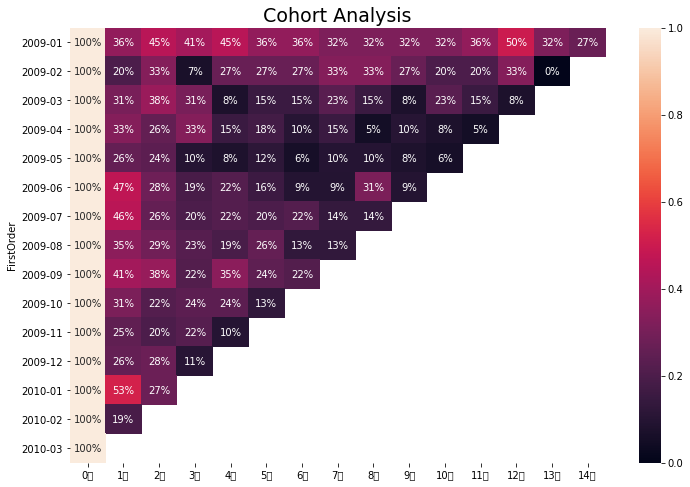

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.figure(figsize=(12, 8))
plt.title('Cohort Analysis', fontsize=19)
sns.heatmap(user_retention, annot=True, fmt='.0%')
plt.show()

### Conclustion

- 해당 서비스를 이용하는 고객분들은 6주차가 되면 재구매활동이 줄어드는 것을 관측할 수 있다. 이를 기준으로 우리 고객들은 6주차부터 재구매를 하지 않는다는 가설을 새워 실험을 해볼 수 있다. 
- 또한, 2009-06, 2009-07, 2009-09, 2010-01 0주차에 큰 폭의 유입이 있는 것으로 관측이 되었다. 이때 행사를 진행하였는지 확인해볼 필요가 있고, 2주차까지 재구매 전환율을 약 50%로 추측해볼 수 있다. 사내에 비교한 프로모션 효율 관련 자료도 함께 검토하여 발견한 인사이트들이 맞는지 확인해볼 수 있다. 